# Introduction

This notebook uses `/MC/Upgrade/Beam7000GeV-Upgrade-MagDown-Nu7.6-25ns-Pythia8/Sim10aU1/13104012/XDIGI` to study the ghost rate of the HLT1 downstream tracking algorithm. The input for this study is obtained by running the `downstream_dump` sequence with all cuts turned off in the reconstruction algorithm.

In [1]:
# The folder of your input JSON files
input_folder = '/hdd/jiahuiz/allen_data/dump/SciFiv6_upgrade_DC19_01_Bs2PhiPhiMD_Ghost/'

# Import packages
All the following packages must be installed prior to running this notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
import math
from tqdm import tqdm
import pickle
import ROOT
import torch
import torch.nn as nn
import torch.optim as optim
import random

Welcome to JupyROOT 6.28/00


# Data struct
The internal data structure of this notebook

In [3]:
class mc_info:
    def __init__(self, data):
        self.true_pid     = data['pid'    ]
        self.true_p       = data['p'      ]
        self.true_pt      = data['pt'     ]
        self.true_eta     = data['eta'    ]
        self.true_charge  = data['charge' ]
        self.ovtx_x       = data['ovtx_x' ]
        self.ovtx_y       = data['ovtx_y' ]
        self.ovtx_z       = data['ovtx_z' ]
        
        # Category
        self.fromBeauty  = data['fromBeautyDecay'  ]
        self.fromCharm   = data['fromCharmDecay'   ]
        self.fromStrange = data['fromStrangeDecay' ]
        self.fromSignal  = data['fromSignal'       ]
        
        # Track type
        self.hasSciFi = data['hasSciFi']
        self.hasUT    = data['hasUT'   ]
        self.hasVelo  = data['hasVelo' ]
        self.isLong   = data['isLong'  ]
        self.isDown   = data['isDown'  ]

In [4]:
class downstream_track:
    def __init__(self, data):
        # Reconstruction result
        self.x    = data['x'   ]
        self.y    = data['y'   ]
        self.z    = data['z'   ]
        self.tx   = data['tx'  ]
        self.ty   = data['ty'  ]
        self.chi2 = data['chi2']
        self.qop  = data['qop' ]
        # SciFi 
        self.scifi_x     = data['scifi']['x'    ]
        self.scifi_y     = data['scifi']['y'    ]
        self.scifi_z     = data['scifi']['z'    ]
        self.scifi_tx    = data['scifi']['tx'   ]
        self.scifi_ty    = data['scifi']['ty'   ]
        self.scifi_chi2X = data['scifi']['chi2X']
        self.scifi_chi2Y = data['scifi']['chi2Y']
        self.scifi_qop   = data['scifi']['qop'  ]
        self.scifi_nY    = data['scifi']['nY'   ]
        self.scifi_nHits = len(data['scifi']['hits' ])
        
        # Truth matching
        self.matched_down = data['is_matched_all']
        self.matched_ut   = data['is_matched_ut']
        
        if self.matched_down : self.mc = mc_info(data['matched_all_mcp'])
        

# Input loading

Loading the JSON input is time-consuming, so after the initial loading, we preselect and store the data in a binary file. This allows us to quickly reload the preselected data from the binary file in the future, which is much faster than reloading everything from JSON.

## Load input from JSON

In [5]:
# READ THE FILE ID FROM FILE NAME
def get_file_id(path):
    return path.replace('.json','').split('_')[-1]


# READ FOLDER
all_files = os.listdir(input_folder)
track_files = [f'{input_folder}/{f}' for f in all_files if 'dump_downstream_tracks_' in f]


In [6]:
tracks = []
for track_path in tqdm(track_files):
    # Load scifi
    with open(track_path,'r') as f:
        track_data = json.loads(f.read())
    tracks += [downstream_track(s) for s in track_data]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


## Save the data into binary file

In [7]:
with open('/hdd/jiahuiz/allen_data/pickle/GhostStudy_Bs2PhiPhiMD_tracks_v1_1.pkl', 'wb') as f:
    pickle.dump(tracks, f)

## Reload the data from binary file

In [5]:
with open('/hdd/jiahuiz/allen_data/pickle/GhostStudy_Bs2PhiPhiMD_tracks_v1_1.pkl', 'rb') as f:
    tracks = pickle.load(f)

# Data vectorization
To expedite the study, we vectorize all data into np.array to enhance operations using SIMD.

In [8]:
# Downstream output
array_downstream_x    = np.array([t.x    for t in tracks])
array_downstream_y    = np.array([t.y    for t in tracks])
array_downstream_z    = np.array([t.z    for t in tracks])
array_downstream_tx   = np.array([t.tx   for t in tracks])
array_downstream_ty   = np.array([t.ty   for t in tracks])
array_downstream_chi2 = np.array([t.chi2 for t in tracks])
array_downstream_qop  = np.array([t.qop  for t in tracks])
# SciFi track
array_scifi_x     = np.array([t.scifi_x     for t in tracks])
array_scifi_y     = np.array([t.scifi_y     for t in tracks])
array_scifi_z     = np.array([t.scifi_z     for t in tracks])
array_scifi_tx    = np.array([t.scifi_tx    for t in tracks])
array_scifi_ty    = np.array([t.scifi_ty    for t in tracks])
array_scifi_chi2X = np.array([t.scifi_chi2X for t in tracks])
array_scifi_chi2Y = np.array([t.scifi_chi2Y for t in tracks])
array_scifi_qop   = np.array([t.scifi_qop   for t in tracks])
array_scifi_nY    = np.array([t.scifi_nY    for t in tracks])
array_scifi_nHits = np.array([t.scifi_nHits for t in tracks])
# Is ghost?
array_is_ghost = np.array([not t.matched_down for t in tracks])
#
# Extention
#

# pt
array_downstream_txy2 = (array_downstream_tx**2 + array_downstream_ty**2)
array_downstream_pt = np.sqrt( array_downstream_txy2 / (1+array_downstream_txy2)) / abs(array_downstream_qop)

# dqop
array_dqop = array_downstream_qop-array_scifi_qop

# p
array_downstream_p = 1/abs(array_downstream_qop)
array_scifi_p = 1/abs(array_downstream_p)

# dp
array_dp = array_downstream_p-array_scifi_p

# Visualization

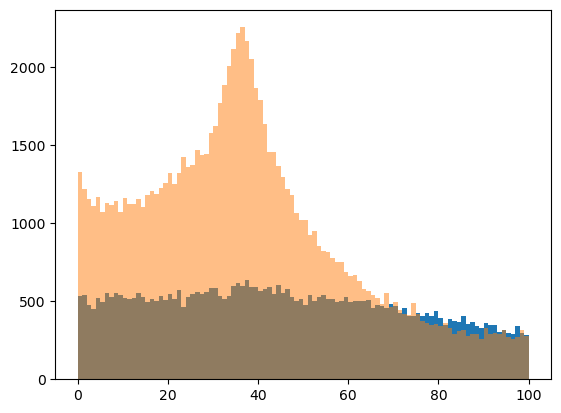

In [9]:
plt.hist(abs(array_downstream_x[array_is_ghost==False]), bins=100, range=(0,100));
plt.hist(abs(array_downstream_x[array_is_ghost==True] ), bins=100, range=(0,100), alpha=0.5);

# Prepare the pytorch

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


## Helpers

In [11]:
def print_array_as_c(array):
    shape = array.shape

    if len(shape) == 1:
        print("{", end="")
        for i, val in enumerate(array):
            if i < shape[0] - 1:
                print(f"{val:0.6e}f, ", end="")
            else:
                print(f"{val:0.6e}f", end="")
        print("};")
    elif len(shape) == 2:
        rows, cols = shape
        print("{")
        for row in range(rows):
            print("  {", end="")
            for col in range(cols):
                if col < cols - 1:
                    print(f"{array[row][col]:0.6e}f, ", end="")
                else:
                    print(f"{array[row][col]:0.6e}f", end="")
            if row < rows - 1:
                print("},")
            else:
                print("}")
        print("};")
    else:
        print("Unsupported array shape.")

In [12]:
def get_pos_weight(y):
    return (y==0.).sum()/y.sum();

## Trainning

----------------------------------------
constexpr unsigned num_node = 14;
constexpr unsigned num_input = 8;
----------------------------------------
Data preprocessing, transformation: 
__device__ constexpr float mean[num_input] = 
{4.641796e+00f, 1.218002e+00f, 2.066622e-03f, 6.105790e-04f, 7.931495e-01f, -4.358424e-06f, 5.505731e+01f, -4.577948e-06f};
__device__ constexpr float std[num_input] = 
{1.352746e+02f, 1.245911e+02f, 5.589610e-02f, 5.300781e-02f, 2.882342e+00f, 1.944772e-04f, 1.236910e+02f, 1.933288e-04f};
----------------------------------------
Epoch 18047, Train Loss: 0.3495732843875885, Val Loss: 0.352214872837066657
Early stopping!

----------------------------------------
For score > 0.7883096516132351
track eff: 0.9499691928527418
ghost rej: 0.6992009132420092
 
For score > 0.5
track eff: 0.828589032655576
ghost rej: 0.8623112047769582
----------------------------------------
__device__ constexpr float weights1[num_node][num_input] = 
{
  {-3.130957e-01f, -1.641726e-

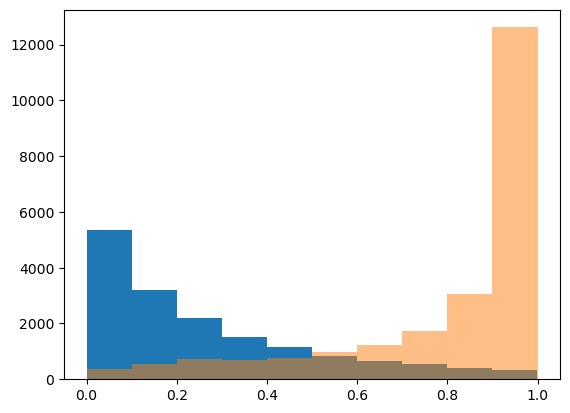

In [13]:
seed_everything(222)

# Define the NN
num_node = 14
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, num_node)  # hiden layer
        self.fc2 = nn.Linear(num_node, 1)  # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Setup input
input_data = {
    # Downstream output
    'downstream_x'   : array_downstream_x,
    'downstream_y'   : array_downstream_y,
    'downstream_tx'   : array_downstream_tx,
    'downstream_ty'   : array_downstream_ty,
    'downstream_chi2': array_downstream_chi2,
    'downstream_qop': array_downstream_qop,
    # SciFi output
    'scifi_chi2Y' : array_scifi_chi2Y,
    'scifi_qop' : array_scifi_qop,
}

# Load input to correct format
X = np.column_stack([input_data[key] for key in input_data])
y = array_is_ghost

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# make input standard
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('----------------------------------------')
print(f'constexpr unsigned num_node = {num_node};')
print(f'constexpr unsigned num_input = {X_train.shape[1]};')
print('----------------------------------------')
print(f'Data preprocessing, transformation: ')
print('__device__ constexpr float mean[num_input] = ')
print_array_as_c(scaler.mean_)

print('__device__ constexpr float std[num_input] = ')
print_array_as_c(scaler.scale_)
print('----------------------------------------')

# convert numpy to tensors
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

# change the shape of tensors
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)
    
# Create NN
net = Net(X_train.shape[1]).to(device)

# Define criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

# Define the early stop
early_stop_epochs = 1000 
best_val_loss = float('inf')  
epochs_no_improve = 0

# Train
for epoch in range(500000):  
    # Trainning
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    # Testing
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test) 
        val_loss = criterion(val_outputs, y_test) 
    net.train()
    # Print
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, loss.item(), val_loss.item()), end='\r')
    # Early stop system
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop_epochs:
            print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, loss.item(), val_loss.item()), end='\n')
            print('Early stopping!')
            break

print('')

print('----------------------------------------')

# Predict
with torch.no_grad():
    outputs = net(X_test).to(torch.device('cpu'))
predictions = (outputs > 0.5).float()

# Check
y_test_cpu = y_test.to(torch.device('cpu'))
plt.hist(outputs[y_test_cpu==0]);
plt.hist(outputs[y_test_cpu==1], alpha=0.5);

test0 = outputs[y_test_cpu==0]
test1 = outputs[y_test_cpu==1]
# print(np.percentile(test0, 95))
cut = np.percentile(test0, 95)

print(f'For score > {cut}')
print('track eff:', len([1 for t in test0 if t<cut]) / len(test0))
print('ghost rej:', len([1 for t in test1 if t>cut]) / len(test1))
print(' ')
print('For score > 0.5')
print('track eff:', len([1 for t in test0 if t<0.5]) / len(test0))
print('ghost rej:', len([1 for t in test1 if t>0.5]) / len(test1))

print('----------------------------------------')
# Export
weights1 = net.fc1.weight.data.to(torch.device('cpu')).numpy()
bias1 = net.fc1.bias.data.to(torch.device('cpu')).numpy()
weights2 = net.fc2.weight.data.to(torch.device('cpu')).numpy()
bias2 = net.fc2.bias.data.to(torch.device('cpu')).numpy()

print(f'__device__ constexpr float weights1[num_node][num_input] = ')
print_array_as_c(weights1)
print(f'__device__ constexpr float bias1[num_node] = ')
print_array_as_c(bias1)
print(f'__device__ constexpr float weights2[num_node] = ')
print_array_as_c(weights2[0])
print(f'__device__ constexpr float bias2 = {bias2[0]:0.6e};')

# Node reduction study

In [51]:
def GetTheGhostRejectionFor95Efficiency(num_node):
    seed_everything(222)
    
    class Net(nn.Module):
        def __init__(self, n_features):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(n_features, num_node)  # hiden layer
            self.fc2 = nn.Linear(num_node, 1)  # output layer

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return torch.sigmoid(self.fc2(x))

    # Setup input
    input_data = {
        # Downstream output
        'downstream_x'   : array_downstream_x,
        'downstream_y'   : array_downstream_y,
        'downstream_tx'   : array_downstream_tx,
        'downstream_ty'   : array_downstream_ty,
        'downstream_chi2': array_downstream_chi2,
        'downstream_qop': array_downstream_qop,
        # SciFi output
        'scifi_chi2Y' : array_scifi_chi2Y,
        'scifi_qop' : array_scifi_qop,
    }

    # Load input to correct format
    X = np.column_stack([input_data[key] for key in input_data])
    y = array_is_ghost

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # make input standard
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # convert numpy to tensors
    X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
    X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
    y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
    y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

    # change the shape of tensors
    y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)

    # Create NN
    net = Net(X_train.shape[1]).to(device)

    # Define criterion and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters())

    # Define the early stop
    early_stop_epochs = 1000 
    best_val_loss = float('inf')  
    epochs_no_improve = 0

    # Train
    for epoch in range(500000):  
        # Trainning
        optimizer.zero_grad()
        outputs = net(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # Testing
        net.eval()
        with torch.no_grad():
            val_outputs = net(X_test) 
            val_loss = criterion(val_outputs, y_test) 
        net.train()
        # Print
        # print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, loss.item(), val_loss.item()), end='\r')
        # Early stop system
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_epochs:
                # print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, loss.item(), val_loss.item()), end='\n')
                # print('Early stopping!')
                break

    # print('')

    # print('----------------------------------------')

    # Predict
    with torch.no_grad():
        outputs = net(X_test).to(torch.device('cpu'))
    predictions = (outputs > 0.5).float()

    # Check
    y_test_cpu = y_test.to(torch.device('cpu'))
    # plt.hist(outputs[y_test_cpu==0]);
    # plt.hist(outputs[y_test_cpu==1], alpha=0.5);

    test0 = outputs[y_test_cpu==0]
    test1 = outputs[y_test_cpu==1]
    # print(np.percentile(test0, 95))
    cut = np.percentile(test0, 95)
    
    return len([1 for t in test1 if t>cut]) / len(test1)

    # print(f'For score > {cut}')
    # print('track eff:', len([1 for t in test0 if t<cut]) / len(test0))
    # print('ghost rej:', len([1 for t in test1 if t>cut]) / len(test1))
    # print(' ')
    # print('For score > 0.5')
    # print('track eff:', len([1 for t in test0 if t<0.5]) / len(test0))
    # print('ghost rej:', len([1 for t in test1 if t>0.5]) / len(test1))

    # print('----------------------------------------')
    # Export
    # weights1 = net.fc1.weight.data.to(torch.device('cpu')).numpy()
    # bias1 = net.fc1.bias.data.to(torch.device('cpu')).numpy()
    # weights2 = net.fc2.weight.data.to(torch.device('cpu')).numpy()
    # bias2 = net.fc2.bias.data.to(torch.device('cpu')).numpy()

    # print(f'__device__ constexpr float weights1[num_node][num_input] = ')
    # print_array_as_c(weights1)
    # print(f'__device__ constexpr float bias1[num_node] = ')
    # print_array_as_c(bias1)
    # print(f'__device__ constexpr float weights2[num_node] = ')
    # print_array_as_c(weights2[0])
    # print(f'__device__ constexpr float bias2 = {bias2[0]:0.6e};')

In [56]:
list_node = range(4, 33)
list_ghost_rejection_rate = [GetTheGhostRejectionFor95Efficiency(n) for n in tqdm(list_node) ] 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [05:35<00:00, 11.57s/it]


In [57]:
print(list_ghost_rejection_rate)

[0.5571319285068502, 0.4236038667501217, 0.6024758328117393, 0.6149245427359343, 0.6248696015021907, 0.6284859865081021, 0.6337714722859726, 0.6358578482509215, 0.639265595660338, 0.6376660407538772, 0.6549134153974546, 0.6596425342513388, 0.6630502816607553, 0.663467556853745, 0.6652757493567008, 0.6635371027192434, 0.6620070936782808, 0.6666666666666666, 0.663467556853745, 0.6616593643507893, 0.6760553585089366, 0.6625634606022672, 0.6689616802281104, 0.675220808122957, 0.6793240141873566, 0.6776549134153974, 0.6884345225676334, 0.6800890187078378, 0.686000417275193]


Text(0, 0.5, 'Ghost rejection rate when efficiency = 95%')

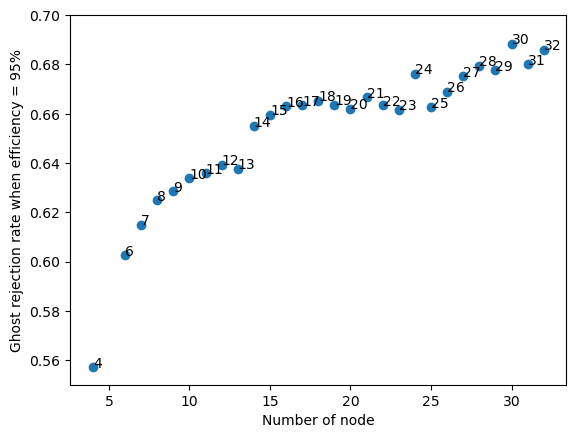

In [75]:
fig, ax = plt.subplots()

plt.scatter(x=list_node, y=list_ghost_rejection_rate)

for i, txt in enumerate(list_node):
    ax.annotate(txt, (list_node[i], list_ghost_rejection_rate[i]))
    
plt.ylim(0.55, 0.7)
plt.xlabel('Number of node')
plt.ylabel('Ghost rejection rate when efficiency = 95%')